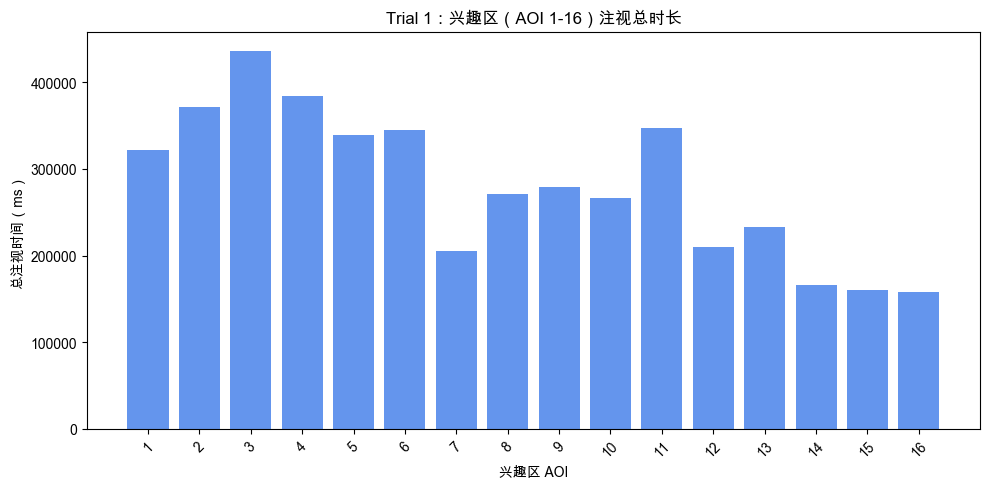

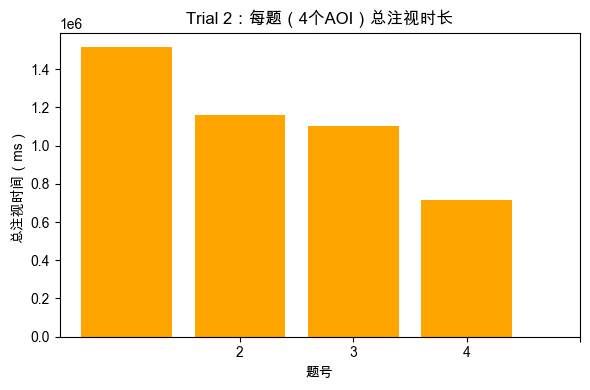

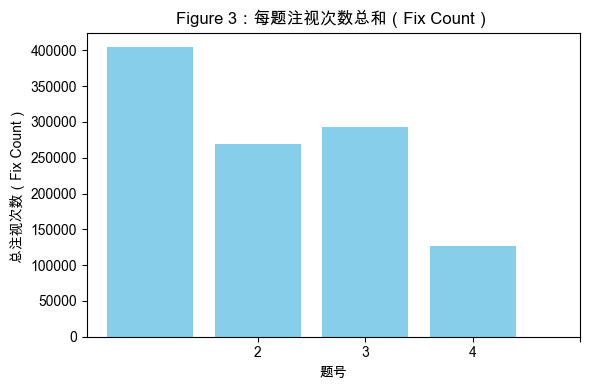

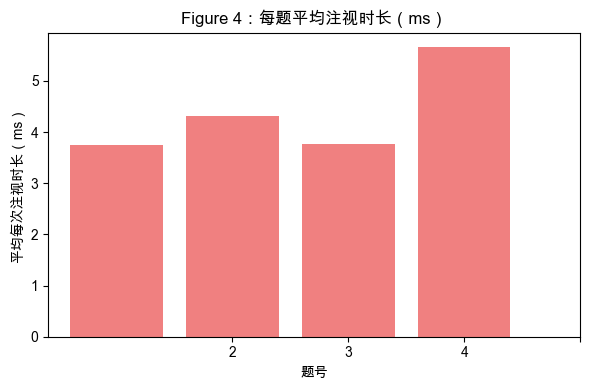

每题的注视总时长（ms）：
1    1514073
2    1160650
3    1102349
4     716136
dtype: int64

每题的注视总次数（Fix Count）：
1    404325
2    269411
3    293247
4    126553
dtype: int64

每题的平均每次注视时长（ms）：
1    3.744693
2    4.308102
3    3.759114
4    5.658783
dtype: float64


In [6]:
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['Arial Unicode MS'] #mac 中文字体，Windows 可将Arial Unicode MS替换为Microsoft YaHei

# 读取数据
df = pd.read_excel("Listening_FixationReport_Raw.xlsx")  # 修改为你的实际路径
df.columns = df.columns.str.strip()  # 清理列名空格

# 仅筛选 Trial 1
df_trial1 = df[df["TRIAL_INDEX"] == 1].copy()

# 去除无效记录（例如 AOI为空，或注视时长为0）
df_trial1 = df_trial1[
    df_trial1["CURRENT_FIX_INTEREST_AREAS"].notnull() &
    (df_trial1["CURRENT_FIX_DURATION"] > 0)
].copy()

# 提取兴趣区编号（如 [ 5] -> 5），转为整型
df_trial1["AOI_ID"] = df_trial1["CURRENT_FIX_INTEREST_AREAS"].astype(str).str.extract(r"\[ *(\d+) *\]").astype(float).astype("Int64")

# 筛选 AOI 在 1~16 范围内的
df_trial1 = df_trial1[df_trial1["AOI_ID"].between(1, 16)]

# ===== 分析 1：统计每个 AOI 的总注视时长 =====
aoi_durations = df_trial1.groupby("AOI_ID")["CURRENT_FIX_DURATION"].sum()

# 可视化：AOI 1~16 注视总时长
plt.figure(figsize=(10, 5))
plt.bar(aoi_durations.index.astype(str), aoi_durations.values, color="cornflowerblue")
plt.title("Trial 1：兴趣区（AOI 1-16）注视总时长")
plt.xlabel("兴趣区 AOI")
plt.ylabel("总注视时间（ms）")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ===== 分析 2：合并为4道题，每题包含4个AOI =====
question_groups = {
    1: list(range(1, 5)),
    2: list(range(5, 9)),
    3: list(range(9, 13)),
    4: list(range(13, 17)),
}

# 汇总每道题的注视总时间
q_durations = {
    q: df_trial1[df_trial1["AOI_ID"].isin(aois)]["CURRENT_FIX_DURATION"].sum()
    for q, aois in question_groups.items()
}
q_series = pd.Series(q_durations)

# 可视化：每题总注视时长
plt.figure(figsize=(6, 4))
plt.bar(q_series.index.astype(str), q_series.values, color="orange")
plt.title("Trial 2：每题（4个AOI）总注视时长")
plt.xlabel("题号")
plt.ylabel("总注视时间（ms）")
plt.xticks([1, 2, 3, 4])
plt.tight_layout()
plt.show()

# ===== 分析 3：每题的注视次数（Fix Count） =====
q_fix_counts = {
    q: df_trial1[df_trial1["AOI_ID"].isin(aois)]["CURRENT_FIX_INTEREST_AREA_FIX_COUNT"].sum()
    for q, aois in question_groups.items()
}
fix_series = pd.Series(q_fix_counts)

# ===== 图3：每题的注视次数 =====
plt.figure(figsize=(6, 4))
plt.bar(fix_series.index.astype(str), fix_series.values, color="skyblue")
plt.title("Figure 3：每题注视次数总和（Fix Count）")
plt.xlabel("题号")
plt.ylabel("总注视次数（Fix Count）")
plt.xticks([1, 2, 3, 4])
plt.tight_layout()
plt.show()

# ===== 图4：每题平均每次注视持续时间（=总时长/注视次数） =====
# 避免除以0，做个保护
avg_duration = q_series / fix_series.replace(0, pd.NA)
plt.figure(figsize=(6, 4))
plt.bar(avg_duration.index.astype(str), avg_duration.values, color="lightcoral")
plt.title("Figure 4：每题平均注视时长（ms）")
plt.xlabel("题号")
plt.ylabel("平均每次注视时长（ms）")
plt.xticks([1, 2, 3, 4])
plt.tight_layout()
plt.show()

# ===== 输出汇总表 =====
print("每题的注视总时长（ms）：")
print(q_series)

print("\n每题的注视总次数（Fix Count）：")
print(fix_series)

print("\n每题的平均每次注视时长（ms）：")
print(avg_duration)

# 🧾 眼动数据分析脚本详解（Trial 1）

本节讲解一段完整的 Python 脚本，用于分析眼动实验数据，主要包括：
- 数据读取与清洗
- 提取兴趣区编号
- 按兴趣区和题目统计注视总时长和次数
- 可视化展示

---

## 📚 第一部分：导入库与设置中文字体

```python
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
```

### 🔍 解释：
- 导入 `pandas` 和 `matplotlib.pyplot`。
- 设置绘图中文字体：
  - macOS 使用 `'Arial Unicode MS'`
  - Windows 推荐使用 `'Microsoft YaHei'`

---

## 📁 第二部分：读取并清理数据

```python
df = pd.read_excel("Listening_FixationReport_Raw.xlsx")
df.columns = df.columns.str.strip()
```

### 🧠 功能说明：
- 从 Excel 文件中读取眼动数据。
- 去除列名两端的空格，防止后续操作因空格出错。

---

## 🔍 第三部分：筛选目标 Trial 和有效数据

```python
df_trial1 = df[df["TRIAL_INDEX"] == 1].copy()

df_trial1 = df_trial1[
    df_trial1["CURRENT_FIX_INTEREST_AREAS"].notnull() &
    (df_trial1["CURRENT_FIX_DURATION"] > 0)
].copy()
```

### 🧠 功能说明：
- 筛选出 `TRIAL_INDEX == 1` 的试验数据。
- 过滤掉无效记录：
  - 兴趣区为空（`CURRENT_FIX_INTEREST_AREAS` 为 `NaN`）
  - 注视时长为 0 的无效记录

---

## 🔢 第四部分：提取 AOI 编号并过滤范围

```python
df_trial1["AOI_ID"] = df_trial1["CURRENT_FIX_INTEREST_AREAS"].astype(str).str.extract(r"\[ *(\d+) *\]").astype(float).astype("Int64")

df_trial1 = df_trial1[df_trial1["AOI_ID"].between(1, 16)]
```

### 🧠 功能说明：
- 将类似 `[ 5]` 的字符串提取为整数 `5`，作为新的 `AOI_ID` 列。
- 过滤只保留 AOI 编号在 1~16 范围内的数据。

---

## 📊 分析 1：统计每个 AOI 的总注视时长

```python
aoi_durations = df_trial1.groupby("AOI_ID")["CURRENT_FIX_DURATION"].sum()
```

### 🧠 功能说明：
- 按兴趣区 ID 分组，统计每组的总注视时间。

---

## 📈 可视化 1：每个 AOI 的注视总时长

```python
plt.figure(figsize=(10, 5))
plt.bar(aoi_durations.index.astype(str), aoi_durations.values, color="cornflowerblue")
plt.title("Trial 1：兴趣区（AOI 1-16）注视总时长")
plt.xlabel("兴趣区 AOI")
plt.ylabel("总注视时间（ms）")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
```

### 🧠 功能说明：
- 绘制柱状图，显示每个 AOI 的总注视时间。
- 设置图表大小、标题、坐标轴标签和自动布局。

---

## 📐 分析 2：将 AOI 合并为 4 道题进行统计

```python
question_groups = {
    1: list(range(1, 5)),
    2: list(range(5, 9)),
    3: list(range(9, 13)),
    4: list(range(13, 17)),
}

q_durations = {
    q: df_trial1[df_trial1["AOI_ID"].isin(aois)]["CURRENT_FIX_DURATION"].sum()
    for q, aois in question_groups.items()
}
q_series = pd.Series(q_durations)
```

### 🧠 功能说明：
- 定义每道题包含的 AOI 区域（如题 1 对应 AOI 1~4）。
- 汇总每道题的总注视时间。

---

## 📈 可视化 2：每道题的注视总时长

```python
plt.figure(figsize=(6, 4))
plt.bar(q_series.index.astype(str), q_series.values, color="orange")
plt.title("Trial 1：每题（4个AOI）总注视时长")
plt.xlabel("题号")
plt.ylabel("总注视时间（ms）")
plt.xticks([1, 2, 3, 4])
plt.tight_layout()
plt.show()
```

### 🧠 功能说明：
- 绘制柱状图，显示每道题的总注视时间。

---

## 🔍 分析 3：统计每题的注视次数（Fix Count）

```python
q_fix_counts = {
    q: df_trial1[df_trial1["AOI_ID"].isin(aois)]["CURRENT_FIX_INTEREST_AREA_FIX_COUNT"].sum()
    for q, aois in question_groups.items()
}
fix_series = pd.Series(q_fix_counts)
```

### 🧠 功能说明：
- 统计每道题对应的累计注视次数（来自 `CURRENT_FIX_INTEREST_AREA_FIX_COUNT` 字段）。

---

## 📈 图3：每题的注视次数总和（Fix Count）

```python
plt.figure(figsize=(6, 4))
plt.bar(fix_series.index.astype(str), fix_series.values, color="skyblue")
plt.title("Trial 1：每题注视次数总和（Fix Count）")
plt.xlabel("题号")
plt.ylabel("总注视次数（Fix Count）")
plt.xticks([1, 2, 3, 4])
plt.tight_layout()
plt.show()
```

### 🧠 功能说明：
- 使用 `fix_series`（之前计算好的每题注视次数）绘制柱状图。
- 设置图表大小、标题、坐标轴标签和刻度。
- 可视化展示每道题的累计注视次数。

---

## ⚖️ 图4：每题平均每次注视持续时间

```python
avg_duration = q_series / fix_series.replace(0, pd.NA)
plt.figure(figsize=(6, 4))
plt.bar(avg_duration.index.astype(str), avg_duration.values, color="lightcoral")
plt.title("Trial 1：每题平均注视时长（ms）")
plt.xlabel("题号")
plt.ylabel("平均每次注视时长（ms）")
plt.xticks([1, 2, 3, 4])
plt.tight_layout()
plt.show()
```

### 🧠 功能说明：
- 计算每题的“平均每次注视时长”：
  - 公式为：总注视时长 ÷ 总注视次数
  - 使用 `.replace(0, pd.NA)` 避免除以零错误
- 绘制柱状图显示每题的平均注视时长，帮助识别注意力集中程度。

---

## 🖨️ 输出汇总表

```python
print("每题的注视总时长（ms）：")
print(q_series)

print("\n每题的注视总次数（Fix Count）：")
print(fix_series)

print("\n每题的平均每次注视时长（ms）：")
print(avg_duration)
```

### 🧠 功能说明：
- 打印三组统计结果，用于查看或导出：
  - 每题的总注视时间
  - 每题的总注视次数
  - 每题的平均注视时长

---

是否需要我帮你将这段内容整合到完整的 `.ipynb` 文件中？或者添加保存图像、多 Trial 分析等功能？````

你可以复制以上内容到 Jupyter Notebook 的 Markdown 单元格中直接使用。如果需要我为你生成图像保存功能或补充异常处理逻辑，请告诉我。